In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [5]:
df = load_pkl('../../data/feat_engin/lgbm/data_1hour_1day.pkl')

In [6]:
df.shape

(1013212, 610)

In [9]:
df.head()

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,tmos_close_1day_w100_ma_up_3std/tmos_close_1day,close_1day_w3_min/close_1day_w3_max,volume_1day_w3_min/volume_1day_w3_max,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max
0,2022-05-05 10:00:00,31.24,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.379999,18,0.001282,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-05-05 11:00:00,30.98,AFLT,0.0,LOSE,1 days 01:00:00,0.98,30.280001,20,-0.008323,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-05-05 12:00:00,30.92,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.280001,20,-0.001937,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-05-05 13:00:00,30.92,AFLT,0.0,LOSE,0 days 23:00:00,0.98,30.280001,20,0.000000,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-05-05 14:00:00,31.00,AFLT,0.0,LOSE,0 days 22:00:00,0.98,30.280001,20,0.002587,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
df['result'].value_counts(normalize=True)

result
DNF     0.470735
LOSE    0.362077
WIN     0.167188
Name: proportion, dtype: float64

In [14]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.987931
0.50    0.996748
0.60    1.003714
0.70    1.012251
0.80    1.026534
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

### 1. train/valid/test/test2 split

In [61]:
df['income_rate'] -= 0.001

In [63]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

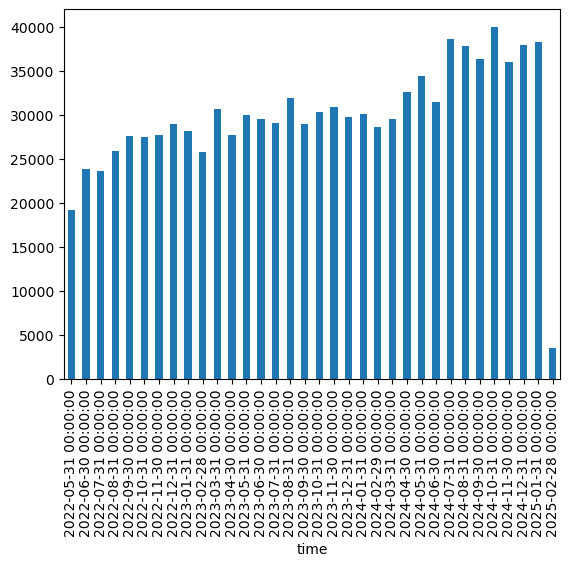

In [65]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

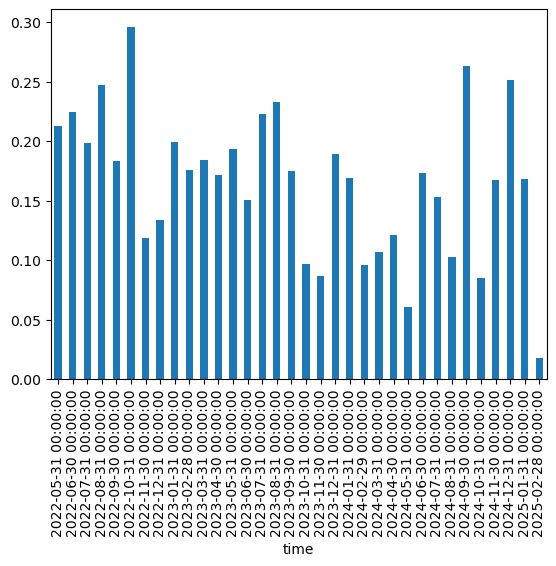

In [66]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

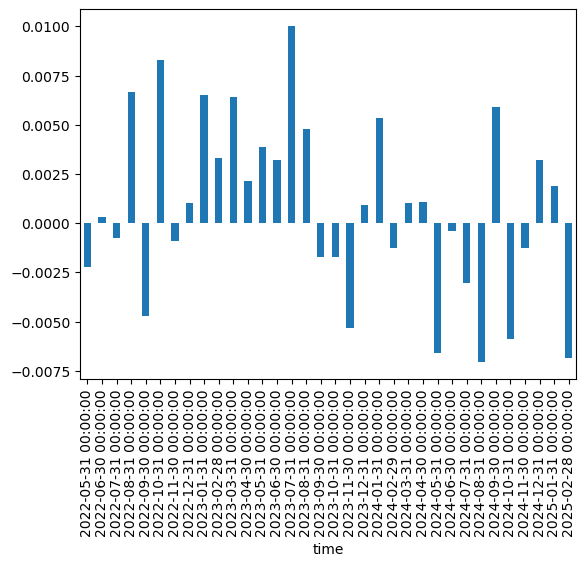

In [69]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [72]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
IRAO       0.058613
LKOH       0.064085
PHOR       0.064876
MTSS       0.069946
ROSN       0.069978
SBERP      0.070782
HYDR       0.070947
SBER       0.076469
TATNP      0.080013
GMKN       0.081505
CBOM       0.083563
GAZP       0.085131
TATN       0.086063
AKRN       0.091426
TRNFP      0.091537
RTKMP      0.091880
RTKM       0.092911
SNGSP      0.093954
MOEX       0.095439
ALRS       0.096296
MGNT       0.099663
MAGN       0.100189
NVTK       0.102497
VTBR       0.103382
SIBN       0.103810
RUAL       0.105973
VSMO       0.107268
PLZL       0.107410
CHMF       0.111544
BELU       0.117674
SGZH       0.118589
POSI       0.121764
NLMK       0.125237
ENPG       0.129032
OGKB       0.129222
KRKNP      0.130577
SNGS       0.133073
UPRO       0.134702
AFKS       0.134942
SMLT       0.135513
PIKK       0.135665
FEES       0.136600
T          0.139029
LSNGP      0.140131
KAZT       0.142382
AFLT       0.143880
MSNG       0.146532
AQUA       0.149157
MSRS       0.151761
YDEX       0.

In [74]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
VSMO       0.997560
SGZH       0.998199
YAKG       0.998468
HYDR       0.998521
LNZL       0.998760
VEON-RX    0.998860
RUAL       0.998956
RKKE       0.998972
SMLT       0.999124
GMKN       0.999157
GAZP       0.999229
ENPG       0.999314
IRKT       0.999343
LNZLP      0.999402
UNAC       0.999492
APTK       0.999523
VTBR       0.999539
NVTK       0.999607
KAZT       0.999660
PHOR       0.999682
KMAZ       0.999698
ABIO       0.999706
ROLO       0.999754
ALRS       0.999761
MAGN       0.999858
MRKS       0.999897
PIKK       0.999907
SPBE       0.999929
CNTLP      1.000003
RTKMP      1.000004
TRNFP      1.000032
UNKL       1.000037
MTLRP      1.000045
KAZTP      1.000049
KRKNP      1.000077
VKCO       1.000079
RTKM       1.000108
OGKB       1.000173
MGNT       1.000205
MVID       1.000272
AKRN       1.000335
KZOSP      1.000347
WUSH       1.000347
T          1.000410
MTSS       1.000412
KZOS       1.000450
MGTSP      1.000486
LIFE       1.000498
UWGN       1.000525
CBOM       1.

In [76]:
df['time'].max()

Timestamp('2025-02-04 23:00:00')

In [78]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
mask_test3 = np.array((pd.Timestamp('2024-12-23') <= df['time']) & (df['time'] < pd.Timestamp('2025-02-02')))

In [80]:
mask_test3.sum()

50342

In [82]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(713114, 70129, 74239, 101909)

In [85]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 101
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [86]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(595945, 70129, 74239, 101909)

In [90]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

842222

In [91]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [94]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7075865983078096,
 0.08326664466138381,
 0.08814659317852062,
 0.12100016385228597)

In [95]:
# 

In [96]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.15871263287719503,
 0.16215830826049138,
 0.1813063214752354,
 0.15419639089776171)

In [97]:
df.loc[mask_test3, 'target'].mean()

0.19210599499423942

In [98]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0019069, 0.99815696, 0.99928683, 0.9974388)

In [99]:
#(1.0027912, 0.99597716, 1.0007247, 1.0005852)

In [100]:
df.loc[mask_test3, 'income_rate'].mean()

1.0034891

In [114]:
#проверки

In [116]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [67]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [79]:
df['ticker_code'].nunique()

127

In [81]:
df.loc[mask_train, 'ticker_code'].nunique()

127

In [83]:
df.columns.tolist()

['time',
 'close',
 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.005',
 'close_w70_lvl_-

In [85]:
drop_cols = ['time',
             #'ticker_code',
             #'hour', 'day', 'weekday', 

 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 
              'ind', 'close',
             'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()
#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] +['hour', 'day', 'weekday'] + #['ticker_code']
                                                                                                    


cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',# 'month'
]
cat_features = cat_features_all

target = 'target'

In [87]:
len(features)

601

### Get stability features

In [95]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": 0,
    "metric": "auc",
    "early_stopping" : 20, 
}

auc_features = {'feature' : [],
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : []
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train, stab_features], label=df.loc[mask_train, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        
    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid])
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

auc_features_cp = auc_features.copy()

100%|███████████████████████████████████████████████████████████████████████| 601/601 [03:39<00:00,  2.74it/s]


In [96]:
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2
0,close_w1_roc,0.586264,0.582300,0.548985,0.567681
1,volume_w1_roc,0.521086,0.514619,0.510316,0.500528
2,tmos_close_w1_roc,0.560174,0.579407,0.535689,0.553500
3,close_w5_norm_std,0.613861,0.625097,0.575112,0.603849
4,close_w5_mean_abs_pct,0.627370,0.638225,0.591427,0.620384
...,...,...,...,...,...
596,tmos_close_1day_w5_min/tmos_close_1day_w5_max,0.589461,0.569867,0.585637,0.576685
597,close_1day_w20_min/close_1day_w20_max,0.640587,0.655043,0.651733,0.624860
598,volume_1day_w20_min/volume_1day_w20_max,0.618923,0.571702,0.554816,0.528048
599,tmos_close_1day_w20_min/tmos_close_1day_w20_max,0.578552,0.566071,0.565083,0.468651


#### auc <=0.525

In [99]:
auc_treshold = 0.51

In [100]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

36

In [101]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

150

In [102]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

185

In [103]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

246

In [105]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

239

In [106]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

323

#### delta_auc > 0.05

In [110]:
auc_delta_treshold  = 0.03

In [111]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

190

In [112]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

218

In [113]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

301

In [115]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

247

In [116]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

375

#### union criterias

In [119]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

415

In [120]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

493

In [122]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(186,
 array(['volume_w1_roc', 'tmos_close_w1_roc', 'volume_w5_norm_std',
        'tmos_close_w5_norm_std', 'tmos_close_w5_rsi', 'tmos_close_w5_roc',
        'close_w14_norm_std', 'close_w14_mean_abs_pct',
        'volume_w14_norm_std', 'volume_w14_mean_abs_pct', 'volume_w14_roc',
        'tmos_close_w14_norm_std', 'tmos_close_w14_alpha',
        'close_w70_norm_std', 'close_w70_roc', 'close_w70_lvl_1.005-1.01',
        'close_w70_lvl_1.01-1.02', 'close_w70_lvl_-0.98-0.99',
        'close_w70_lvl_1.02-1.03',
        'close_w70_lvl_-0.9299999999999999-0.95',
        'volume_w70_mean_abs_pct', 'volume_w70_roc',
        'tmos_close_w70_lvl_1-1.005', 'tmos_close_w70_lvl_1.005-1.01',
        'tmos_close_w70_lvl_1.01-1.015', 'tmos_close_w70_lvl_1.02-1.03',
        'close_w1_roc/close_w5_alpha', 'close_w1_roc/close_w14_alpha',
        'close_w1_roc/close_w70_alpha', 'volume_w1_roc/volume_w5_alpha',
        'volume_w1_roc/volume_w70_alpha',
        'tmos_close_w1_roc/tmos_close_w5_alpha',
    

In [123]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
231,close_w70_min/close_w70_max,0.652385,0.673664,0.638020,0.607973
19,close_w14_mean_abs_pct,0.649618,0.660875,0.635691,0.657418
597,close_1day_w20_min/close_1day_w20_max,0.640587,0.655043,0.651733,0.624860
33,close_w70_norm_std,0.639077,0.654086,0.630947,0.608198
267,close_1day_w20_norm_std,0.637814,0.652787,0.643576,0.611318
...,...,...,...,...,...
388,close_1day_w1_roc/close_1day_w5_roc,0.513155,0.511820,0.516609,0.497312
195,volume_w5_ma_low_3std/volume,0.515626,0.511261,0.519382,0.503679
161,volume/volume_w70_ma,0.520880,0.510975,0.525896,0.498457
196,volume_w5_ma_up_3std/volume,0.514970,0.510433,0.515738,0.504567


In [852]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(108,
 array(['tmos_close_w1_roc', 'tmos_close_w5_norm_std', 'tmos_close_w5_rsi',
        'tmos_close_w5_roc', 'close_w14_norm_std',
        'close_w14_mean_abs_pct', 'volume_w14_norm_std',
        'volume_w14_mean_abs_pct', 'volume_w14_roc',
        'tmos_close_w14_norm_std', 'close_w70_lvl_1.005-1.01',
        'close_w70_lvl_1.01-1.02', 'close_w70_lvl_-0.98-0.99',
        'close_w70_lvl_1.02-1.03', 'volume_w70_mean_abs_pct',
        'volume_w70_roc', 'tmos_close_w70_lvl_1-1.005',
        'tmos_close_w70_lvl_1.005-1.01', 'tmos_close_w70_lvl_1.01-1.015',
        'close_w1_roc/close_w5_alpha', 'close_w1_roc/close_w14_alpha',
        'close_w1_roc/close_w70_alpha',
        'tmos_close_w1_roc/tmos_close_w5_alpha',
        'volume_w1_roc/volume_w70_roc', 'volume_w5_roc/volume_w14_roc',
        'tmos_close_w1_roc/tmos_close_w5_roc',
        'close_w5_mean_abs_pct/close_w70_mean_abs_pct',
        'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
        'volume_w14_mean_abs_pct/volume_w70_mea

In [854]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
19,close_w14_mean_abs_pct,0.649618,0.660875,0.635691,0.657418
597,close_1day_w20_min/close_1day_w20_max,0.640587,0.655043,0.651733,0.624860
267,close_1day_w20_norm_std,0.637814,0.652787,0.643576,0.611318
492,close_1day/close_1day_w100_ma,0.620976,0.648658,0.627060,0.609867
228,close_w14_min/close_w14_max,0.627486,0.644950,0.605292,0.634436
18,close_w14_norm_std,0.623074,0.642326,0.598200,0.627482
495,close_1day_w3_ma/close_1day_w100_ma,0.619979,0.638052,0.611349,0.610366
497,close_1day_w5_ma/close_1day_w100_ma,0.613435,0.634187,0.610457,0.604054
271,close_1day_w20_roc,0.608946,0.631626,0.604792,0.603094
319,close_1day_w100_lvl_1.01-1.02,0.595585,0.624420,0.586116,0.616915


In [922]:
features = features_criteria2.tolist()
cat_features = [feature for feature in features if feature in cat_features_all]

In [924]:
len(features), len(cat_features)

(108, 0)

In [926]:
'ticker_code' in features

False

In [928]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [932]:
# def mean_income_rate(y_pred, data):
#     q = 0.98
#     mask = y_pred >= np.quantile(y_pred, q)
#     score = round(data.income_rate[mask].mean(), 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

def mean_income_rate(y_pred, D_sample):
    q = 0.98
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 5)
    
    return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.2,
     "bagging_fraction": 0.2,
     "bagging_freq": 1,
    # 'lambda_l1' : 10,
    # 'lambda_l2' : 10,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    "metric": "auc",
    #"metric" : 'mean_income_rate',
    "early_stopping" : 50,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.702351	valid_0's mean_income_rate: 0.09161


In [934]:
model.num_trees()

96

In [937]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6957374384138081, 0.702350636621373, 0.6662594765460901, 0.6717788127817512)

In [944]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.529830
LOSE    0.353693
DNF     0.116477
Name: proportion, dtype: float64
1.0146801

Test
result
WIN     0.669355
LOSE    0.278226
DNF     0.052419
Name: proportion, dtype: float64
1.0214626

Test2
result
WIN     0.441176
LOSE    0.325490
DNF     0.233333
Name: proportion, dtype: float64
1.0128857


In [947]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.35809901628524277

Valid
result
WIN     0.529830
LOSE    0.353693
DNF     0.116477
Name: proportion, dtype: float64
1.0146801

Test
result
WIN     0.484337
LOSE    0.404217
DNF     0.111446
Name: proportion, dtype: float64
1.0124959

Tetst2
result
WIN     0.411208
LOSE    0.328239
DNF     0.260553
Name: proportion, dtype: float64
1.0121012


In [950]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 19:00:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('1 days 03:00:00'))

In [953]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(704, 3320, 1374)

In [955]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(13, 23, 20)

In [957]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'SPBE', 'MTLRP', 'FESH', 'KROT', 'VKCO', 'MRKY', 'SELG',
       'SGZH', 'CHMK', 'YAKG', 'RKKE', 'MRKZ', 'CNTL', 'AFKS', 'UNKL',
       'LNZL', 'NSVZ', 'RNFT', 'VRSB', 'UWGN', 'TGKN', 'ABIO', 'WUSH',
       'RTKMP', 'GTRK', 'NLMK', 'CNTLP', 'BLNG', 'ALRS', 'LSNG', 'TRNFP',
       'MGNT', 'TGKB', 'ROLO', 'IRKT', 'MTLR', 'HEAD', 'KLSB', 'SIBN',
       'MSTT', 'KAZTP', 'DVEC', 'VTBR', 'AMEZ', 'MRKU', 'TRMK', 'VEON-RX',
       'RTKM', 'SMLT', 'UNAC', 'PIKK', 'TGKBP', 'POSI', 'MRKS', 'MAGN',
       'PRFN', 'RBCM'], dtype=object)

In [959]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_59687/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
LNZL,1.0,1.040000
HEAD,1.0,0.980000
POSI,2.0,1.040000
VTBR,3.0,1.035204
MRKY,3.0,1.007381
TRMK,3.0,1.017540
ABIO,4.0,1.040000
TRNFP,4.0,0.995000
KAZTP,4.0,1.025000


In [962]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w14_mean_abs_pct', 24.76),
 ('close_1day_w20_min/close_1day_w20_max', 21.54),
 ('close_1day_w20_norm_std', 7.29),
 ('close_w14_min/close_w14_max', 5.58),
 ('close_1day_w100_lvl_1.02-1.03', 5.11),
 ('tmos_close_1day_w5_min/tmos_close_1day_w5_max', 4.77),
 ('tmos_close_w70_lvl_1-1.005', 3.97),
 ('close_1day_w5_ma/close_1day_w100_ma', 3.06),
 ('tmos_close_1day_w5_norm_std', 2.99),
 ('close_1day_w100_lvl_1.01-1.02', 2.84),
 ('tmos_close_1day_w20_rsi', 2.69),
 ('tmos_close_w14_ma/tmos_close_w70_ma', 1.48),
 ('tmos_close/tmos_close_w70_ma', 1.44),
 ('volume_1day_w20_rsi', 1.44),
 ('close_w14_ma_low_3std/close', 1.19),
 ('tmos_close_1day_w5_std/tmos_close_1day_w100_std', 0.92),
 ('close_w70_lvl_1.02-1.03', 0.85),
 ('tmos_close_1day_w5_ma_up_3std/tmos_close_1day', 0.82),
 ('close_1day_w20_roc', 0.78),
 ('close_w70_lvl_1.01-1.02', 0.71),
 ('tmos_close_w5_ma/tmos_close_w14_ma', 0.69),
 ('close_w14_max/close', 0.62),
 ('close_1day_w5_norm_std/close_1day_w100_norm_std', 0.62),
 ('volume_1

# 3.2 Tuning hyperparams

In [973]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [975]:
len(top_features), len(top_cat_features)

(33, 0)

In [977]:
top_features

['close_w14_mean_abs_pct',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_1.02-1.03',
 'volume_w70_mean_abs_pct',
 'tmos_close_w70_lvl_1-1.005',
 'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
 'close_w5_ma/close_w70_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w5_ma/tmos_close_w14_ma',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w14_max/close',
 'tmos_close_w14_max/tmos_close',
 'close_w14_ma_low_3std/close',
 'tmos_close_w14_ma_up_3std/tmos_close',
 'close_w14_min/close_w14_max',
 'tmos_close_1day_w5_norm_std',
 'close_1day_w20_norm_std',
 'close_1day_w20_roc',
 'close_1day_w20_lvl_1.02-1.03',
 'volume_1day_w20_rsi',
 'tmos_close_1day_w20_rsi',
 'close_1day_w100_lvl_1.01-1.02',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w3_std/close_1day_w100_std',
 'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
 'close_1day_w5_norm_std/close_1day_w100_norm_std',
 'volume_1day_w5_norm_std/volume_1day_w20_norm_std',
 'volume_1day_w20_rsi/volume_1day_w100_rsi',
 'close_1day/close_1day_

In [980]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [139]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score

In [986]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [988]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.014680147171020508, 0.012495875358581543, 0.012101173400878906)

In [990]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.011852448, 0.0047178864, 0.013002518)

In [992]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.07883256028384664, 0.05551745448001596, 0.09696792811155319)

In [998]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.98)
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.0916141233471937, 0.04906291921817979, 0.05025496655854128)

In [1013]:
bagging_fraction

1.0000000000000002

In [1015]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
    
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],


           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],

          
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=3*1*3*19*19)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [0.1, 1, 10]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 4, 8]:
            for feature_fraction in np.arange(0.1, 1.05, 0.05)[::-1]:
                for bagging_fraction in np.arange(0.1, 1.05, 0.05)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": "auc",
                                "early_stopping" : 50,
                            }
                    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.98)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]


                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]

                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████| 3249/3249 [1:35:21<00:00,  1.76s/it]


In [1016]:
dump_pkl(history, './history.pkl')

In [576]:
history = load_pkl('./history.pkl')

In [1019]:
pd.set_option('display.max_columns', 100)
df_hst = pd.DataFrame(history)
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",180,0.709310,0.711370,0.665880,0.654268,0.016900,0.008269,0.014141,0.007279,0.012921,0.009389,0.009756,0.003442,0.009437,-0.002498,0.002328,0.004532,0.007732,0.000826,0.004283,0.005140,0.064465,-0.014058,0.028584,0.043935,0.092045,0.010141,0.065745,0.067081
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",206,0.711453,0.711629,0.664115,0.648250,0.016822,0.009061,0.014234,0.007833,0.012808,0.009768,0.009811,0.003829,0.009795,-0.003507,0.003677,0.006503,0.008395,0.001503,0.002695,0.003653,0.077733,-0.023327,0.047034,0.060623,0.110481,0.019998,0.042750,0.049037
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",174,0.708843,0.712369,0.664179,0.654574,0.016498,0.009893,0.014129,0.008459,0.012289,0.009885,0.009841,0.004337,0.009419,-0.002214,0.001965,0.007012,0.007706,0.000791,0.002646,0.003635,0.073802,-0.013591,0.024134,0.062747,0.097533,0.009718,0.041970,0.047445
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",172,0.708881,0.711805,0.664187,0.653380,0.016575,0.009754,0.014279,0.008325,0.012301,0.009471,0.009771,0.004231,0.010146,-0.000138,0.006101,0.004949,0.007971,0.001276,0.003177,0.003273,0.072364,-0.000777,0.074910,0.047981,0.101291,0.013712,0.048761,0.042719
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",151,0.706672,0.710634,0.664791,0.657265,0.016353,0.009918,0.014724,0.009587,0.011973,0.009750,0.010051,0.004209,0.009217,-0.000560,0.004268,0.006029,0.007415,0.001675,0.004317,0.002105,0.068982,-0.003724,0.052410,0.051707,0.092372,0.018850,0.066259,0.026685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244,"{'boosting_type': 'gbdt', 'objective': 'binary...",86,0.731295,0.708465,0.675583,0.651713,0.021285,0.015795,0.014155,0.009606,0.017011,0.013489,0.010730,0.007378,0.014863,0.009534,0.006635,0.001571,0.008675,0.001457,0.002100,0.001286,0.114968,0.063413,0.091657,0.018742,0.118958,0.020127,0.035450,0.022539
3245,"{'boosting_type': 'gbdt', 'objective': 'binary...",78,0.729191,0.704231,0.668931,0.649717,0.018613,0.013577,0.011657,0.006560,0.015874,0.010529,0.009205,0.005549,0.010839,0.002410,0.005944,0.002365,0.007739,-0.000761,0.002021,0.002173,0.113244,0.030829,0.091239,0.030868,0.116227,-0.012854,0.035163,0.040506
3246,"{'boosting_type': 'gbdt', 'objective': 'binary...",78,0.728040,0.704918,0.674443,0.654101,0.019685,0.014813,0.012039,0.010171,0.016611,0.012193,0.009768,0.007146,0.011583,0.009219,0.004609,0.003439,0.009211,0.001037,0.003258,0.000898,0.114616,0.080184,0.075452,0.046160,0.133245,0.016972,0.056667,0.016071
3247,"{'boosting_type': 'gbdt', 'objective': 'binary...",78,0.727799,0.707285,0.675621,0.645961,0.019246,0.012550,0.011726,0.007698,0.016263,0.011390,0.009918,0.006983,0.009991,0.001846,0.006998,0.004506,0.007390,-0.000484,0.006201,0.001978,0.096849,0.017941,0.100251,0.057122,0.104674,-0.007422,0.101524,0.033182


### threshold delta AUC

In [1021]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(3163, 356, 116)

In [1023]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(356, 94)

In [1043]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
358,"{'boosting_type': 'gbdt', 'objective': 'binary...",119,0.699178,0.715838,0.669452,0.668242,0.016316,0.015548,0.014922,0.010016,0.011217,0.012756,0.010142,0.006314,0.010413,0.009028,0.000436,0.008030,0.006950,0.009437,0.005372,0.002841,0.060672,0.036951,0.004683,0.065877,0.083778,0.096566,0.079706,0.036024
1441,"{'boosting_type': 'gbdt', 'objective': 'binary...",119,0.699154,0.715810,0.669497,0.668258,0.016237,0.015478,0.014806,0.009955,0.011111,0.012756,0.010075,0.006335,0.010389,0.009013,0.000447,0.008073,0.006779,0.009556,0.005262,0.002868,0.060534,0.036888,0.004803,0.066225,0.082058,0.097778,0.078074,0.036358
1327,"{'boosting_type': 'gbdt', 'objective': 'binary...",87,0.697348,0.713956,0.668666,0.672627,0.011129,0.011687,0.011812,0.010756,0.008153,0.011753,0.009074,0.005109,0.007955,0.009935,0.008080,0.007812,0.007477,0.010125,0.002826,0.002964,0.079516,0.066077,0.115758,0.084471,0.097272,0.119142,0.043369,0.043099
1309,"{'boosting_type': 'gbdt', 'objective': 'binary...",82,0.695888,0.713597,0.668819,0.672436,0.012326,0.010985,0.011456,0.009415,0.008919,0.011590,0.009483,0.005484,0.008574,0.007990,0.003087,0.010557,0.006236,0.004858,0.004462,0.005668,0.059860,0.044969,0.034751,0.090541,0.072353,0.059651,0.066200,0.065515
2240,"{'boosting_type': 'gbdt', 'objective': 'binary...",94,0.698617,0.712807,0.669149,0.671301,0.012304,0.011719,0.013610,0.010630,0.009571,0.010672,0.010375,0.005719,0.007492,0.005304,0.005909,0.008851,0.006764,0.006814,0.005440,0.005259,0.062093,0.032566,0.069530,0.082508,0.085274,0.076700,0.083496,0.062755


In [ ]:
#1309

In [1037]:
df_hst.columns

Index(['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test',
       'auc_test2', 'mir_point@1_train', 'mir_point@1_valid',
       'mir_point@1_test', 'mir_point@1_test2', 'mir_point@2_train',
       'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2',
       'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test',
       'mir_day@1_test2', 'mir_day@2_train', 'mir_day@2_valid',
       'mir_day@2_test', 'mir_day@2_test2', 'mir_month@1_train',
       'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2',
       'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test',
       'mir_month@2_test2'],
      dtype='object')

### threshold income_rate

In [1359]:
col = 'mir_month@1'
threshold = 0.07
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(133, 663, 410)

In [1361]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(65, 8)

In [1363]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



8

In [1366]:
col = 'mir_day@1'
threshold = 0.007

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(752, 492, 1200)

In [1368]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(179, 65)

In [1370]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

65

In [1373]:
(mask_ir&mask2_ir).sum()

4

In [1375]:
df_hst.loc[mask_ir&mask2_ir].sort_values(by=f'auc_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
186,"{'boosting_type': 'gbdt', 'objective': 'binary...",107,0.700604,0.714429,0.667331,0.664917,0.014880,0.010401,0.012476,0.006897,0.011095,0.011072,0.009295,0.003620,0.008845,0.014039,0.007753,0.007531,0.006953,0.005958,0.004361,0.002630,0.067976,0.093377,0.103131,0.075825,0.081369,0.064012,0.066932,0.033340
2463,"{'boosting_type': 'gbdt', 'objective': 'binary...",148,0.700850,0.713315,0.669490,0.666302,0.013608,0.011188,0.012791,0.008725,0.010454,0.010017,0.009247,0.005167,0.006496,0.010906,0.008380,0.008171,0.007403,0.002023,0.003396,0.003685,0.061016,0.078116,0.111467,0.091403,0.095932,0.028985,0.052131,0.050843
2369,"{'boosting_type': 'gbdt', 'objective': 'binary...",112,0.701058,0.712114,0.666239,0.664986,0.015093,0.008034,0.012414,0.007867,0.010967,0.007329,0.009441,0.004806,0.008395,0.013583,0.007743,0.009219,0.007388,0.009479,0.004145,0.005261,0.063670,0.104239,0.099037,0.085935,0.089065,0.111538,0.065739,0.064732
2082,"{'boosting_type': 'gbdt', 'objective': 'binary...",15,0.705644,0.701653,0.680597,0.671145,0.020563,0.016053,0.013703,0.011943,0.017507,0.011186,0.011759,0.009692,0.014574,0.015329,0.008048,0.008165,0.010989,0.003027,0.005483,0.001517,0.040993,0.078429,0.082350,0.076117,0.057405,0.023230,0.078553,0.023197


### creation

In [1230]:
mask_must = (df_hst['mir_day@1_train'] > df_hst['mir_day@2_train']) & (df_hst['mir_day@1_valid'] > df_hst['mir_day@2_valid']) & (df_hst['mir_day@1_test'] > df_hst['mir_day@2_test']) & (df_hst['mir_day@1_test2'] > df_hst['mir_day@2_test2'])
mask_must.sum()

706

In [1234]:
df_hst.loc[mask_must].sort_values(by=f'mir_month@2_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
2126,"{'boosting_type': 'gbdt', 'objective': 'binary...",26,0.710598,0.707653,0.669989,0.649252,0.021870,0.014721,0.017025,0.007587,0.018512,0.012794,0.014278,0.003733,0.012472,0.009853,0.009132,0.005619,0.012325,0.009533,0.005950,0.001934,0.046984,0.080655,0.065414,0.054472,0.069335,0.131695,0.076104,0.023793
1437,"{'boosting_type': 'gbdt', 'objective': 'binary...",119,0.699232,0.714472,0.667438,0.666408,0.016583,0.014638,0.014479,0.010284,0.012151,0.012812,0.009529,0.007176,0.010107,0.015199,0.007144,0.005078,0.007558,0.012340,0.004852,0.003069,0.048228,0.062210,0.080412,0.045441,0.084655,0.126271,0.069511,0.040054
354,"{'boosting_type': 'gbdt', 'objective': 'binary...",119,0.699243,0.714487,0.667414,0.666404,0.016659,0.014553,0.014514,0.010174,0.012163,0.012812,0.009547,0.007156,0.010427,0.015191,0.007154,0.005021,0.007550,0.012340,0.004908,0.003057,0.049230,0.062179,0.080523,0.044933,0.084564,0.126271,0.070305,0.039893
2514,"{'boosting_type': 'gbdt', 'objective': 'binary...",119,0.699484,0.713060,0.668787,0.666301,0.015879,0.010736,0.014389,0.010293,0.011429,0.011136,0.009634,0.006930,0.010194,0.016399,0.004205,0.007392,0.006917,0.012317,0.004118,0.003143,0.061957,0.075512,0.051629,0.068908,0.082683,0.119731,0.063208,0.039851
1049,"{'boosting_type': 'gbdt', 'objective': 'binary...",12,0.693587,0.708424,0.671579,0.671043,0.018506,0.015121,0.014025,0.008555,0.014367,0.012937,0.011470,0.006840,0.007832,0.008400,0.002484,0.004966,0.005611,0.007766,-0.000719,0.000220,0.042092,0.077359,0.038124,0.061104,0.062004,0.119196,-0.013612,0.003773


In [1377]:
df_hst.iloc[[1309, 2463, 2369]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
1309,"{'boosting_type': 'gbdt', 'objective': 'binary...",82,0.695888,0.713597,0.668819,0.672436,0.012326,0.010985,0.011456,0.009415,0.008919,0.011590,0.009483,0.005484,0.008574,0.007990,0.003087,0.010557,0.006236,0.004858,0.004462,0.005668,0.059860,0.044969,0.034751,0.090541,0.072353,0.059651,0.066200,0.065515
2463,"{'boosting_type': 'gbdt', 'objective': 'binary...",148,0.700850,0.713315,0.669490,0.666302,0.013608,0.011188,0.012791,0.008725,0.010454,0.010017,0.009247,0.005167,0.006496,0.010906,0.008380,0.008171,0.007403,0.002023,0.003396,0.003685,0.061016,0.078116,0.111467,0.091403,0.095932,0.028985,0.052131,0.050843
2369,"{'boosting_type': 'gbdt', 'objective': 'binary...",112,0.701058,0.712114,0.666239,0.664986,0.015093,0.008034,0.012414,0.007867,0.010967,0.007329,0.009441,0.004806,0.008395,0.013583,0.007743,0.009219,0.007388,0.009479,0.004145,0.005261,0.063670,0.104239,0.099037,0.085935,0.089065,0.111538,0.065739,0.064732


In [1379]:
df_hst['params'].iloc[2369] #<---

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5000000000000001,
 'bagging_fraction': 0.3500000000000001,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [1381]:
df_hst['params'].iloc[2463]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.25000000000000006,
 'bagging_fraction': 0.40000000000000013,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

# Feature selection

In [1477]:
len(top_features), top_features

(33,
 ['close_w14_mean_abs_pct',
  'close_w70_lvl_1.01-1.02',
  'close_w70_lvl_1.02-1.03',
  'volume_w70_mean_abs_pct',
  'tmos_close_w70_lvl_1-1.005',
  'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
  'close_w5_ma/close_w70_ma',
  'tmos_close/tmos_close_w70_ma',
  'tmos_close_w5_ma/tmos_close_w14_ma',
  'tmos_close_w14_ma/tmos_close_w70_ma',
  'close_w14_max/close',
  'tmos_close_w14_max/tmos_close',
  'close_w14_ma_low_3std/close',
  'tmos_close_w14_ma_up_3std/tmos_close',
  'close_w14_min/close_w14_max',
  'tmos_close_1day_w5_norm_std',
  'close_1day_w20_norm_std',
  'close_1day_w20_roc',
  'close_1day_w20_lvl_1.02-1.03',
  'volume_1day_w20_rsi',
  'tmos_close_1day_w20_rsi',
  'close_1day_w100_lvl_1.01-1.02',
  'close_1day_w100_lvl_1.02-1.03',
  'close_1day_w3_std/close_1day_w100_std',
  'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
  'close_1day_w5_norm_std/close_1day_w100_norm_std',
  'volume_1day_w5_norm_std/volume_1day_w20_norm_std',
  'volume_1day_w20_rsi/volume_1day_w1

In [95]:
top_features = ['close_w14_mean_abs_pct',
  'close_w70_lvl_1.01-1.02',
  'close_w70_lvl_1.02-1.03',
  'volume_w70_mean_abs_pct',
  'tmos_close_w70_lvl_1-1.005',
  'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
  'close_w5_ma/close_w70_ma',
  'tmos_close/tmos_close_w70_ma',
  'tmos_close_w5_ma/tmos_close_w14_ma',
  'tmos_close_w14_ma/tmos_close_w70_ma',
  'close_w14_max/close',
  'tmos_close_w14_max/tmos_close',
  'close_w14_ma_low_3std/close',
  'tmos_close_w14_ma_up_3std/tmos_close',
  'close_w14_min/close_w14_max',
  'tmos_close_1day_w5_norm_std',
  'close_1day_w20_norm_std',
  'close_1day_w20_roc',
  'close_1day_w20_lvl_1.02-1.03',
  'volume_1day_w20_rsi',
  'tmos_close_1day_w20_rsi',
  'close_1day_w100_lvl_1.01-1.02',
  'close_1day_w100_lvl_1.02-1.03',
  'close_1day_w3_std/close_1day_w100_std',
  'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
  'close_1day_w5_norm_std/close_1day_w100_norm_std',
  'volume_1day_w5_norm_std/volume_1day_w20_norm_std',
  'volume_1day_w20_rsi/volume_1day_w100_rsi',
  'close_1day/close_1day_w100_ma',
  'close_1day_w5_ma/close_1day_w100_ma',
  'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
  'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
  'close_1day_w20_min/close_1day_w20_max']

In [97]:
#features = features_criteria2.tolist()
features = top_features


cat_features = []

In [99]:
len(features), len(cat_features)

(33, 0)

In [101]:
'ticker_code' in features

False

In [103]:
target = 'target'

In [105]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [107]:
D_test2.data

,close_w14_mean_abs_pct,close_w70_lvl_1.01-1.02,close_w70_lvl_1.02-1.03,volume_w70_mean_abs_pct,tmos_close_w70_lvl_1-1.005,close_w14_mean_abs_pct/close_w70_mean_abs_pct,close_w5_ma/close_w70_ma,tmos_close/tmos_close_w70_ma,tmos_close_w5_ma/tmos_close_w14_ma,tmos_close_w14_ma/tmos_close_w70_ma,...,close_1day_w3_std/close_1day_w100_std,tmos_close_1day_w5_std/tmos_close_1day_w100_std,close_1day_w5_norm_std/close_1day_w100_norm_std,volume_1day_w5_norm_std/volume_1day_w20_norm_std,volume_1day_w20_rsi/volume_1day_w100_rsi,close_1day/close_1day_w100_ma,close_1day_w5_ma/close_1day_w100_ma,tmos_close_1day_w5_ma_up_3std/tmos_close_1day,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max
8236,0.003961,15.0,3.0,1.490307,16.0,0.969775,1.002983,0.990908,0.995651,1.001861,...,0.142085,0.098721,0.109765,0.526666,0.956359,0.990324,0.989518,1.026375,0.983633,0.837273
8237,0.004123,21.0,4.0,1.492058,2.0,0.998964,1.000172,0.984522,0.993687,1.000071,...,0.142085,0.098721,0.109765,0.526666,0.956359,0.990324,0.989518,1.026375,0.983633,0.837273
8238,0.004222,4.0,2.0,1.493076,16.0,0.992985,0.999939,0.991305,0.992313,0.999317,...,0.142085,0.098721,0.109765,0.526666,0.956359,0.990324,0.989518,1.026375,0.983633,0.837273
8239,0.004512,9.0,2.0,1.491756,9.0,1.064376,0.999915,0.989866,0.991715,0.998468,...,0.142085,0.098721,0.109765,0.526666,0.956359,0.990324,0.989518,1.026375,0.983633,0.837273
8240,0.004242,5.0,2.0,1.493121,6.0,0.996351,1.000391,0.988425,0.991660,0.997737,...,0.142085,0.098721,0.109765,0.526666,0.956359,0.990324,0.989518,1.026375,0.983633,0.837273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005861,0.012130,1.0,0.0,5.146770,1.0,1.442168,1.079123,1.079241,1.038457,1.032019,...,0.052559,0.189029,0.167056,1.026487,1.033822,0.684095,0.686933,1.024304,0.977528,0.743154
1005862,0.012483,0.0,0.0,5.153590,2.0,1.470383,1.078168,1.076286,1.037158,1.036638,...,0.052559,0.189029,0.167056,1.026487,1.033822,0.684095,0.686933,1.024304,0.977528,0.743154
1005863,0.011935,0.0,0.0,5.156600,0.0,1.417903,1.080856,1.080740,1.034163,1.041404,...,0.052559,0.189029,0.167056,1.026487,1.033822,0.684095,0.686933,1.024304,0.977528,0.743154
1005864,0.012227,1.0,0.0,5.158228,0.0,1.444231,1.080474,1.081429,1.030124,1.046159,...,0.052559,0.189029,0.167056,1.026487,1.033822,0.684095,0.686933,1.024304,0.977528,0.743154


In [110]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5000000000000001,
 'bagging_fraction': 0.3500000000000001,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [111]:
model.num_trees()

167

In [115]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7086664277601837,
 0.7130201483959963,
 0.6681000633686929,
 0.6562172824090529)

In [117]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.464387
WIN     0.390313
DNF     0.145299
Name: proportion, dtype: float64
1.0068669

Test
result
WIN     0.650538
LOSE    0.252688
DNF     0.096774
Name: proportion, dtype: float64
1.0213258

Test2
result
WIN     0.417154
LOSE    0.370370
DNF     0.212476
Name: proportion, dtype: float64
1.0104413


In [119]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 15:30:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('0 days 23:00:00'))

In [121]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 20:00:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('0 days 23:00:00'))

In [124]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.3778566265844373

Valid
result
LOSE    0.464387
WIN     0.390313
DNF     0.145299
Name: proportion, dtype: float64
1.0068669

Test
result
WIN     0.485480
LOSE    0.387276
DNF     0.127244
Name: proportion, dtype: float64
1.0131007

Tetst2
result
LOSE    0.450176
WIN     0.325397
DNF     0.224427
Name: proportion, dtype: float64
1.0057018


In [126]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 17:00:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('1 days 01:00:00'))

In [128]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 20:00:00'),
 Timedelta('0 days 21:00:00'),
 Timedelta('1 days 00:00:00'))

In [130]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(702, 3788, 2268)

In [132]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(13, 26, 27)

In [135]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [141]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.006866931915283203, 0.013100743293762207, 0.005701780319213867)

In [143]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0071033696, 0.0030348783, 0.0076159528)

In [145]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.04724566738099553, 0.04037093910453625, 0.07667586330513833)

In [148]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'FEES', 'FESH', 'KROT',
       'VKCO', 'SELG', 'SGZH', 'YAKG', 'RKKE', 'MRKZ', 'CNTL', 'PLZL',
       'AFKS', 'UNKL', 'NSVZ', 'RNFT', 'VRSB', 'UWGN', 'TGKN', 'ABIO',
       'WUSH', 'RTKMP', 'GTRK', 'NLMK', 'CNTLP', 'BLNG', 'ALRS', 'LSNG',
       'TRNFP', 'MGNT', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MTLR', 'KLSB',
       'SIBN', 'MSTT', 'KAZTP', 'DVEC', 'VTBR', 'AMEZ', 'MRKU', 'VEON-RX',
       'CHMF', 'RTKM', 'SMLT', 'UNAC', 'PIKK', 'TGKBP', 'POSI', 'KZOS',
       'MRKS', 'MAGN', 'PRFN', 'BANEP', 'AQUA', 'RBCM'], dtype=object)

In [150]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_82201/859047173.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
TGKA,1.0,0.980000
KRKNP,1.0,1.040000
CNTLP,2.0,1.016748
SBERP,3.0,1.020000
KZOSP,4.0,1.040000
LSNGP,6.0,1.030971
CBOM,6.0,1.010000
RTKM,10.0,1.028000
KAZTP,10.0,1.026327


# Drop weak features

In [155]:
# features = ['close_w14_mean_abs_pct',
#   'close_w70_lvl_1.01-1.02',
#   'close_w70_lvl_1.02-1.03',
#   'volume_w70_mean_abs_pct',
#   'tmos_close_w70_lvl_1-1.005',
#   'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
#   'close_w5_ma/close_w70_ma',
#   'tmos_close/tmos_close_w70_ma',
#   'tmos_close_w5_ma/tmos_close_w14_ma',
#   'tmos_close_w14_ma/tmos_close_w70_ma',
#   'close_w14_max/close',
#   'tmos_close_w14_max/tmos_close',
#   'close_w14_ma_low_3std/close',
#   'tmos_close_w14_ma_up_3std/tmos_close',
#   'close_w14_min/close_w14_max',
#   'tmos_close_1day_w5_norm_std',
#   'close_1day_w20_norm_std',
#   'close_1day_w20_roc',
#   'close_1day_w20_lvl_1.02-1.03',
#   'volume_1day_w20_rsi',
#   'tmos_close_1day_w20_rsi',
#   'close_1day_w100_lvl_1.01-1.02',
#   'close_1day_w100_lvl_1.02-1.03',
#   'close_1day_w3_std/close_1day_w100_std',
#   'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
#   'close_1day_w5_norm_std/close_1day_w100_norm_std',
#   'volume_1day_w5_norm_std/volume_1day_w20_norm_std',
#   'volume_1day_w20_rsi/volume_1day_w100_rsi',
#   'close_1day/close_1day_w100_ma',
#   'close_1day_w5_ma/close_1day_w100_ma',
#   'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
#   'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
#   'close_1day_w20_min/close_1day_w20_max']

In [157]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('volume_w70_mean_abs_pct', 0.0),
 ('tmos_close_w5_ma/tmos_close_w14_ma', 0.0),
 ('tmos_close_w14_ma_up_3std/tmos_close', 0.0),
 ('close_1day_w20_lvl_1.02-1.03', 0.0),
 ('volume_1day_w20_rsi/volume_1day_w100_rsi', 0.16),
 ('close_1day_w100_lvl_1.01-1.02', 0.31),
 ('close_w5_ma/close_w70_ma', 0.33),
 ('tmos_close_w14_ma/tmos_close_w70_ma', 0.41),
 ('close_1day/close_1day_w100_ma', 0.45),
 ('close_w14_max/close', 0.46),
 ('volume_1day_w5_norm_std/volume_1day_w20_norm_std', 0.57),
 ('close_w14_min/close_w14_max', 0.78),
 ('close_w70_lvl_1.01-1.02', 0.88),
 ('close_1day_w5_norm_std/close_1day_w100_norm_std', 0.92),
 ('tmos_close_1day_w5_ma_up_3std/tmos_close_1day', 1.03),
 ('tmos_close_1day_w5_std/tmos_close_1day_w100_std', 1.04),
 ('close_1day_w3_std/close_1day_w100_std', 1.05),
 ('close_1day_w20_roc', 1.25),
 ('close_w70_lvl_1.02-1.03', 1.37),
 ('tmos_close_1day_w5_norm_std', 1.6),
 ('volume_1day_w20_rsi', 1.65),
 ('close_1day_w20_norm_std', 1.69),
 ('close_w14_ma_low_3std/close', 1.96)

In [159]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['volume_1day_w20_rsi/volume_1day_w100_rsi',
 'close_1day_w100_lvl_1.01-1.02',
 'close_w5_ma/close_w70_ma',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_1day/close_1day_w100_ma',
 'close_w14_max/close',
 'volume_1day_w5_norm_std/volume_1day_w20_norm_std',
 'close_w14_min/close_w14_max',
 'close_w70_lvl_1.01-1.02',
 'close_1day_w5_norm_std/close_1day_w100_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
 'close_1day_w3_std/close_1day_w100_std',
 'close_1day_w20_roc',
 'close_w70_lvl_1.02-1.03',
 'tmos_close_1day_w5_norm_std',
 'volume_1day_w20_rsi',
 'close_1day_w20_norm_std',
 'close_w14_ma_low_3std/close',
 'tmos_close_w14_max/tmos_close',
 'close_1day_w5_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w70_lvl_1-1.005',
 'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
 'tmos_close_1day_w20_rsi',
 'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w20_m

In [161]:
cat_features = []

In [163]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5000000000000001,
 'bagging_fraction': 0.3500000000000001,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [165]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.99)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


100%|█████████████████████████████████████████████████████████████████████████| 29/29 [00:41<00:00,  1.44s/it]


In [168]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[volume_1day_w20_rsi/volume_1day_w100_rsi, clo...",173,0.709397,0.711710,0.667374,0.657250,0.016577,0.007454,0.014255,0.007365,0.011060,0.002852,0.004454,0.004239,0.076105,0.013134,0.054694,0.036352
1,"[close_1day_w100_lvl_1.01-1.02, close_w5_ma/cl...",132,0.703698,0.715215,0.669647,0.663970,0.014282,0.007997,0.012158,0.007206,0.010513,0.005378,0.006314,0.008455,0.086073,0.035773,0.083986,0.091428
2,"[close_w5_ma/close_w70_ma, tmos_close_w14_ma/t...",196,0.711007,0.713660,0.664821,0.651566,0.016600,0.007724,0.013924,0.008385,0.011427,0.000557,0.004673,0.005905,0.087245,0.003135,0.057377,0.048440
3,"[tmos_close_w14_ma/tmos_close_w70_ma, close_1d...",160,0.707535,0.713853,0.667087,0.657768,0.016358,0.007028,0.013039,0.007455,0.010419,0.006594,0.006349,0.008478,0.077973,0.026988,0.074707,0.079034
4,"[close_1day/close_1day_w100_ma, close_w14_max/...",130,0.704319,0.715388,0.665981,0.664589,0.012706,0.006312,0.011901,0.005814,0.009332,0.002155,0.005957,0.003243,0.092342,0.014335,0.082290,0.033855
5,"[close_w14_max/close, volume_1day_w5_norm_std/...",157,0.707028,0.714351,0.668184,0.658885,0.015756,0.008318,0.013213,0.006485,0.009051,0.003875,0.003704,0.008725,0.076375,0.025773,0.049277,0.084583
6,[volume_1day_w5_norm_std/volume_1day_w20_norm_...,127,0.702706,0.714367,0.666597,0.664872,0.013152,0.007028,0.011928,0.006026,0.008404,0.006042,0.007617,0.008076,0.075559,0.034006,0.097425,0.087329
7,"[close_w14_min/close_w14_max, close_w70_lvl_1....",128,0.701594,0.714698,0.667691,0.660693,0.015105,0.006382,0.013174,0.008002,0.009460,0.004778,0.008717,0.007940,0.067000,0.022002,0.089193,0.071053
8,"[close_w70_lvl_1.01-1.02, close_1day_w5_norm_s...",187,0.708985,0.714150,0.667283,0.653384,0.017044,0.006689,0.013446,0.006791,0.010277,0.001799,0.006614,0.008844,0.078459,0.010126,0.077827,0.085740
9,[close_1day_w5_norm_std/close_1day_w100_norm_s...,153,0.706082,0.711603,0.664151,0.656748,0.013949,0.007421,0.013012,0.005819,0.009508,0.007313,0.007632,0.007867,0.088353,0.056124,0.089804,0.082141


In [352]:
df_hst_fe['features'].loc[9]

['close_1day_w5_norm_std/close_1day_w100_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
 'close_1day_w3_std/close_1day_w100_std',
 'close_1day_w20_roc',
 'close_w70_lvl_1.02-1.03',
 'tmos_close_1day_w5_norm_std',
 'volume_1day_w20_rsi',
 'close_1day_w20_norm_std',
 'close_w14_ma_low_3std/close',
 'tmos_close_w14_max/tmos_close',
 'close_1day_w5_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w70_lvl_1-1.005',
 'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
 'tmos_close_1day_w20_rsi',
 'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w20_min/close_1day_w20_max',
 'close_w14_mean_abs_pct']

# BEST

In [121]:
features_fe = ['close_1day_w5_norm_std/close_1day_w100_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
 'close_1day_w3_std/close_1day_w100_std',
 'close_1day_w20_roc',
 'close_w70_lvl_1.02-1.03',
 'tmos_close_1day_w5_norm_std',
 'volume_1day_w20_rsi',
 'close_1day_w20_norm_std',
 'close_w14_ma_low_3std/close',
 'tmos_close_w14_max/tmos_close',
 'close_1day_w5_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w70_lvl_1-1.005',
 'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
 'tmos_close_1day_w20_rsi',
 'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w20_min/close_1day_w20_max',
 'close_w14_mean_abs_pct']

params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5000000000000001,
 'bagging_fraction': 0.3500000000000001,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
   #       'num_iteration' : 153,
 'early_stopping': 50
         }

In [123]:
target = 'target'
cat_features = []

In [125]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score

In [127]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [129]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [102]:
#model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [103]:
#dump_pkl(model, './model.pkl')

In [131]:
model = load_pkl('./model.pkl')

In [133]:
model.num_trees()

153

In [137]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7060814872915671,
 0.7116004576483778,
 0.6641306792027345,
 0.6567371949359049)

In [139]:
#(0.6991796450333699, 0.711124788951288, 0.666424281844504, 0.6650550666662738)

In [141]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5939555775361233

In [145]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.452991
WIN     0.401709
DNF     0.145299
Name: proportion, dtype: float64
1.0064211

Test
result
WIN     0.655080
LOSE    0.239305
DNF     0.105615
Name: proportion, dtype: float64
1.0209363

Test2
result
WIN     0.39630
LOSE    0.35443
DNF     0.24927
Name: proportion, dtype: float64
1.0089811


In [147]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.424603
WIN     0.386905
DNF     0.188492
Name: proportion, dtype: float64
1.0080456


In [149]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 16:00:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('1 days 01:00:00'))

In [151]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('1 days 01:00:00')

In [154]:
#общий threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.3668169577019395

Valid
result
LOSE    0.452991
WIN     0.401709
DNF     0.145299
Name: proportion, dtype: float64
1.0064211

Test
result
WIN     0.483561
LOSE    0.387062
DNF     0.129377
Name: proportion, dtype: float64
1.0120118

Tetst2
result
LOSE    0.440565
WIN     0.321280
DNF     0.238155
Name: proportion, dtype: float64
1.0048438


In [156]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(15, 23, 28)

In [158]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.414116
WIN     0.350340
DNF     0.235544
Name: proportion, dtype: float64
1.0070285


In [160]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 17:00:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('1 days 02:00:00'))

In [162]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('1 days 03:30:00')

In [165]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
threshold

0.3668169577019395

In [168]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.006421089172363281, 0.01201176643371582, 0.0048438310623168945)

In [171]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.006311945, 0.0066315015, 0.0068722516)

In [174]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.0484405093024983, 0.07803580816835165, 0.07175096616906634)

In [178]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.007028460502624512

In [181]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.005995866

In [184]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.077325994855371

In [188]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'FESH', 'KROT', 'VKCO',
       'MRKY', 'SELG', 'SGZH', 'CHMK', 'YAKG', 'RKKE', 'MRKZ', 'CNTL',
       'PLZL', 'AFKS', 'UNKL', 'APTK', 'NSVZ', 'LIFE', 'RNFT', 'VRSB',
       'UWGN', 'TGKN', 'ABIO', 'WUSH', 'RTKMP', 'GTRK', 'NLMK', 'CNTLP',
       'BLNG', 'ALRS', 'VSMO', 'LSNG', 'TRNFP', 'MGNT', 'NKHP', 'TGKB',
       'ROLO', 'IRKT', 'MTLR', 'RUAL', 'KLSB', 'SIBN', 'MSTT', 'KAZTP',
       'DVEC', 'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'VEON-RX', 'CHMF', 'RTKM',
       'SMLT', 'LNZLP', 'UNAC', 'PIKK', 'TGKBP', 'POSI', 'KZOS', 'MRKS',
       'MAGN', 'PRFN', 'BANEP', 'AQUA', 'RBCM'], dtype=object)

In [190]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
LIFE,1.0,0.979000
VSMO,1.0,1.039000
TRNFP,1.0,1.039000
APTK,1.0,0.979000
RUAL,1.0,1.039000
LNZLP,1.0,1.023691
MRKU,2.0,1.039000
FEES,2.0,0.991976
MRKY,2.0,1.009000


In [193]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
LSNG,1.0,0.979000
RTKM,3.0,1.039000
SGZH,4.0,0.979000
AMEZ,6.0,0.988779
BLNG,6.0,0.991968
TRNFP,7.0,1.026810
SELG,7.0,0.982664
TRMK,10.0,1.015943
MAGN,11.0,1.004722


In [195]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [199]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [203]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('tmos_close_1day_w5_ma_up_3std/tmos_close_1day', 0.73),
 ('close_1day_w3_std/close_1day_w100_std', 0.78),
 ('close_1day_w5_norm_std/close_1day_w100_norm_std', 0.91),
 ('tmos_close_1day_w5_norm_std', 0.98),
 ('tmos_close_1day_w5_std/tmos_close_1day_w100_std', 1.24),
 ('close_1day_w20_roc', 1.34),
 ('volume_1day_w20_rsi', 1.75),
 ('close_w70_lvl_1.02-1.03', 1.79),
 ('tmos_close_w14_max/tmos_close', 2.46),
 ('tmos_close/tmos_close_w70_ma', 2.63),
 ('close_1day_w5_ma/close_1day_w100_ma', 2.94),
 ('tmos_close_w70_lvl_1-1.005', 3.23),
 ('close_w14_mean_abs_pct/close_w70_mean_abs_pct', 3.33),
 ('close_w14_ma_low_3std/close', 4.19),
 ('tmos_close_1day_w20_rsi', 4.21),
 ('close_1day_w100_lvl_1.02-1.03', 5.62),
 ('tmos_close_1day_w5_min/tmos_close_1day_w5_max', 6.38),
 ('close_1day_w20_min/close_1day_w20_max', 9.36),
 ('close_1day_w20_norm_std', 13.41),
 ('close_w14_mean_abs_pct', 32.74)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

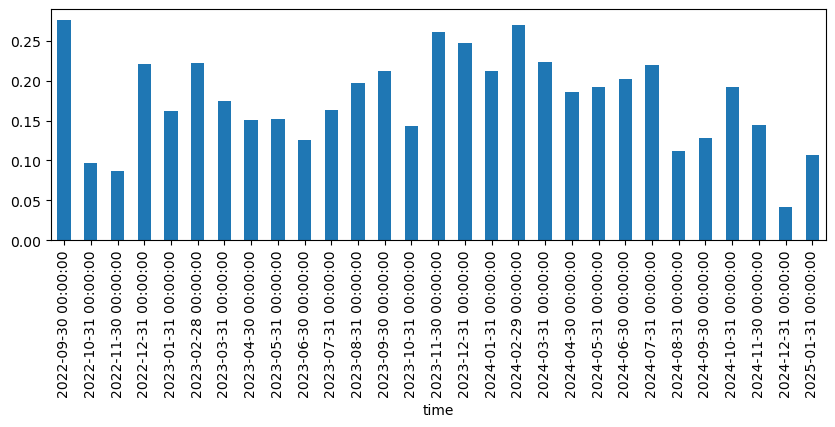

In [208]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [212]:
np.quantile(df.loc[mask_train, 'y_pred'], q=q), np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

(0.38728132422970235, 0.3668169577019395)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/1725577466.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

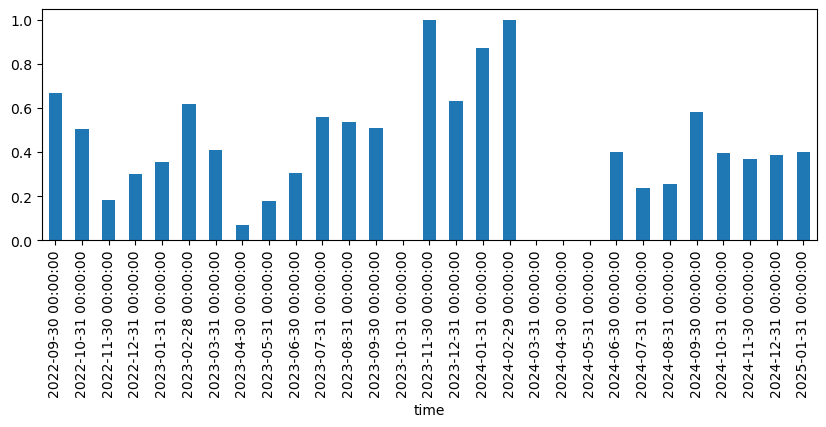

In [215]:
q = 0.99
col_target = 'target'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_train, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/7551147.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


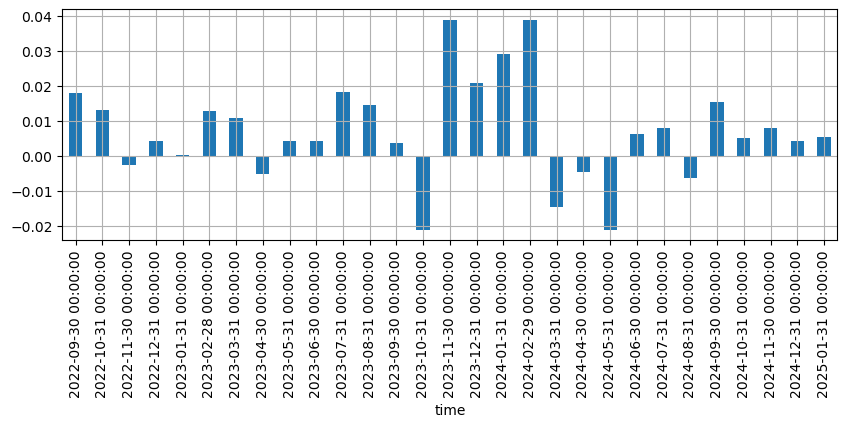

In [219]:
#точечный


q = 0.99
col_target = 'income_rate'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

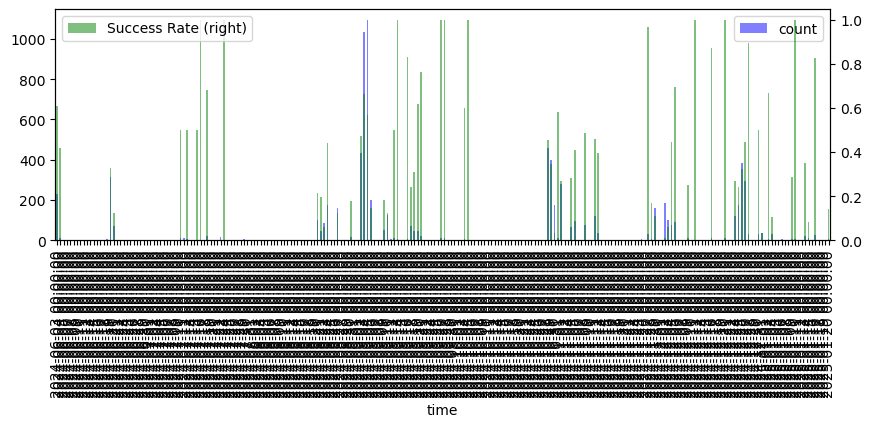

INCOME_RATE


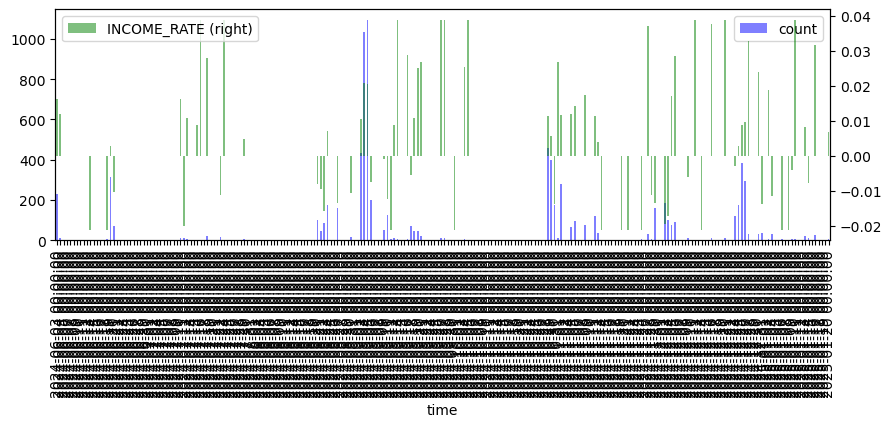

In [222]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [225]:
#y_test3

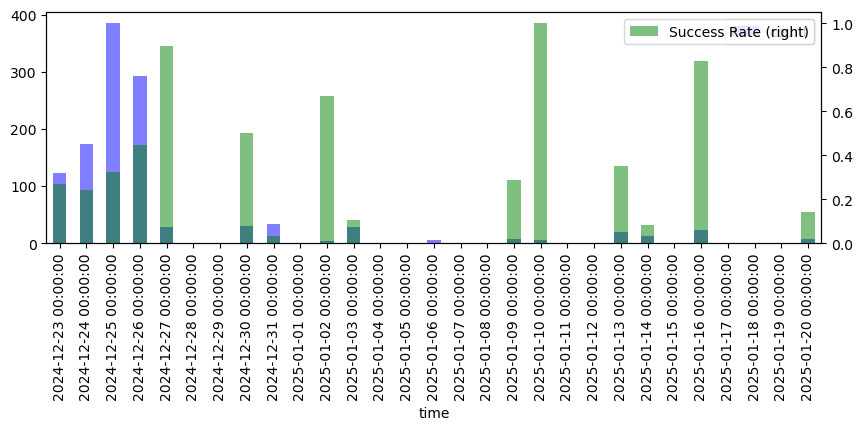

INCOME_RATE


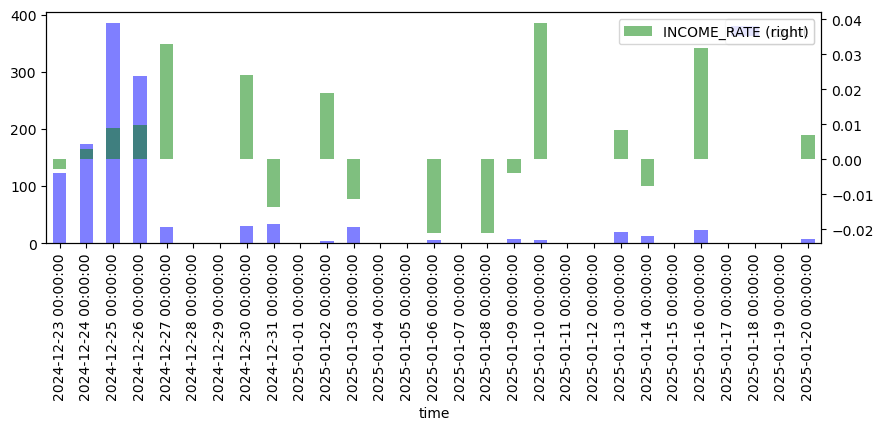

In [227]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [230]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.006311945, 0.0066315015, 0.0068722516)

In [232]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(15, 23, 28)

In [234]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [236]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.0484405093024983, 0.07803580816835165, 0.07175096616906634)

In [239]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.005995866

In [241]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

17

In [243]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.077325994855371

In [247]:
mask_data = mask_valid | mask_test | mask_test2

In [249]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.007424792557051687

In [252]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.004035663604736328

In [254]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.00829927040183026

In [256]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.008522076266152518

In [258]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.005551457405090332

### Points in life

In [267]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe])

threshold = 0.3668169577019395
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_95524/590185056.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20    7
2025-01-21    0
2025-01-22    0
2025-01-23    0
2025-01-24    0
2025-01-25    0
2025-01-26    0
2025-01-27    0
2025-01-28    0
2025-01-29    0
2025-01-30    0
2025-01-31    0
2025-02-01    0
2025-02-02    0
2025-02-03    0
2025-02-04    0
Freq: D, dtype: int64

In [272]:
df.loc[(df['y_pred'] > threshold) & mask_dev]

,time,close,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,...,volume_1day_w3_min/volume_1day_w3_max,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,target,y_pred
775407,2025-01-20 11:00:00,43.549999,VEON-RX,68055.0,DNF,3 days 01:00:00,1.008185,43.950001,776313,-0.002291,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,0,0.37484
775408,2025-01-20 12:00:00,43.549999,VEON-RX,68055.0,DNF,3 days 01:00:00,1.003592,43.750000,776314,0.000000,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,0,0.3691
775409,2025-01-20 13:00:00,43.799999,VEON-RX,68055.0,DNF,3 days 03:00:00,0.997858,43.750000,776315,0.005741,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,0,0.370813
775410,2025-01-20 14:00:00,43.349998,VEON-RX,68055.0,DNF,3 days 04:00:00,1.002460,43.500000,776316,-0.010274,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,0,0.382638
775411,2025-01-20 15:00:00,43.549999,VEON-RX,68055.0,DNF,3 days 19:00:00,0.996704,43.450001,776317,0.004614,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,0,0.370813
775412,2025-01-20 16:00:00,43.849998,VEON-RX,68055.0,DNF,3 days 19:00:00,1.001280,43.950001,776318,0.006889,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,0,0.370813
775413,2025-01-20 17:00:00,43.400002,VEON-RX,68055.0,WIN,3 days 19:00:00,1.039000,45.900002,776319,-0.010262,...,0.301814,0.982946,0.924242,0.270196,0.964341,0.686147,0.0178,0.813954,1,0.37484


# 

### Обучить на всем (эксперимент неудачен)

In [250]:
mask_data = mask_train | mask_valid | mask_test | mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [263]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [265]:
features_fe = ['close_1day_w5_norm_std/close_1day_w100_norm_std',
 'tmos_close_1day_w5_ma_up_3std/tmos_close_1day',
 'tmos_close_1day_w5_std/tmos_close_1day_w100_std',
 'close_1day_w3_std/close_1day_w100_std',
 'close_1day_w20_roc',
 'close_w70_lvl_1.02-1.03',
 'tmos_close_1day_w5_norm_std',
 'volume_1day_w20_rsi',
 'close_1day_w20_norm_std',
 'close_w14_ma_low_3std/close',
 'tmos_close_w14_max/tmos_close',
 'close_1day_w5_ma/close_1day_w100_ma',
 'tmos_close/tmos_close_w70_ma',
 'tmos_close_w70_lvl_1-1.005',
 'close_w14_mean_abs_pct/close_w70_mean_abs_pct',
 'tmos_close_1day_w20_rsi',
 'tmos_close_1day_w5_min/tmos_close_1day_w5_max',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w20_min/close_1day_w20_max',
 'close_w14_mean_abs_pct']

params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5000000000000001,
 'bagging_fraction': 0.3500000000000001,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 #'metric': 'auc',
          'num_iteration' : 153,
# 'early_stopping': 50
         }

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_data)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [269]:
model.num_trees()

153

In [271]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.6975954151975302

In [273]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5597503841597529

In [275]:
threshold = 0.3668169577019395#np.quantile(df.loc[mask_data, 'y_pred'], q=0.99)
threshold
#0.3668169577019395

0.3668169577019395

In [277]:
mean_income_rate_point(D_data, y_pred_data, threshold=threshold)

0.015038490295410156

In [279]:
mean_income_rate_day(D_data, y_pred_data, threshold=threshold)

0.0070446134

In [281]:
mean_income_rate_month(D_data, y_pred_data, threshold=threshold)

0.053166893293272774

In [283]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.010228395462036133

In [285]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.010330456

In [287]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.09090801551938058

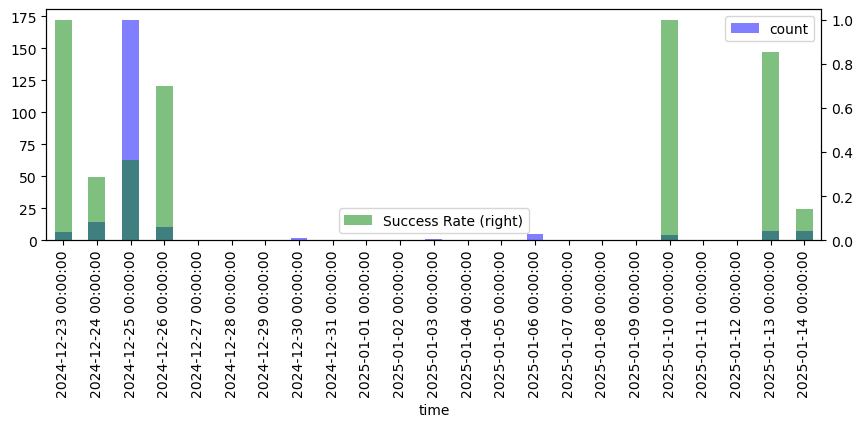

INCOME_RATE


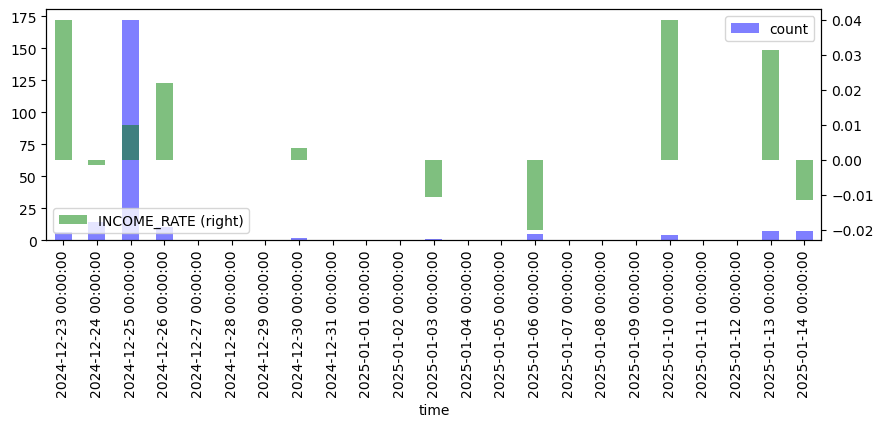

In [289]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()